In [1]:
"""
copy from kaggle
"""

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # #里面有很多颜色映射表

import tensorflow as tf

# settings
LEARNING_RATE = 1e-4   # 学习率
# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 2500    # 训练轮数     
    
DROPOUT = 0.5      # 正则化
BATCH_SIZE = 50    # batch大小

# set to 0 to train on all available data
VALIDATION_SIZE = 2000   # 验证集大小

# image number to output
IMAGE_TO_DISPLAY = 10      # 用来展示的图片数量

In [2]:
# read training data from CSV file 
data = pd.read_csv('./train.csv')   # 读取训练集

print('data({0[0]},{0[1]})'.format(data.shape))  # 打印数据集的大小
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [3]:
images = data.iloc[:,1:].values # 取第1列之后的数据
images = images.astype(np.float) # 转成浮点数

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)  # 将值除以255.0

print('images({0[0]},{0[1]})'.format(images.shape))  # 打印训练集大小

images(42000,784)


In [4]:
image_size = images.shape[1]  # 图像大小
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8) #  np.ceil(x)计算大于等于x的最小整数,np.sqrt()求平方根

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


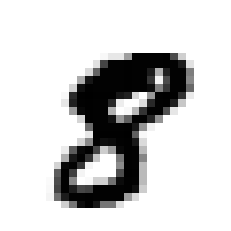

In [5]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height) # 改变形状
    
    plt.axis('off')             # 关闭坐标轴
    plt.imshow(one_image, cmap=cm.binary)  # plt.imshow()函数负责对图像进行处理，并显示其格式

# output image     
display(images[IMAGE_TO_DISPLAY])   # 调用display()方法，显示图片

In [8]:
labels_flat = data[['label']].values.ravel() # 转成一维数组，不会产生源数据副本

print('labels_flat({0})'.format(len(labels_flat))) # 打印label数量
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


In [34]:
labels_count = np.unique(labels_flat)
labels_count
labels_count.shape

(10,)

In [9]:
labels_count = np.unique(labels_flat).shape[0]    # np.unique()函数是去除数组中的重复数字，并进行排序之后输出。.shape得到元组(10,)。.shape[0]取元组的第一个值

print('labels_count => {0}'.format(labels_count))  # 打印去重后的label数

labels_count => 10


In [10]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]                           # label数
    index_offset = np.arange(num_labels) * num_classes           # 返回[0, 10, 20, ...],因为后面flat会得到一维的迭代器，每行10个元素，所以这里表示每一行
    labels_one_hot = np.zeros((num_labels, num_classes))         # 全0矩阵
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1 # .flat返回迭代器，index_offset指定行，labels_dense.ravel()指定列，进而实现one-hot编码
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)       # 调用函数，进行one-hot编码
labels = labels.astype(np.uint8)                           # 转成int

print('labels({0[0]},{0[1]})'.format(labels.shape))        # 打印labels形状，样本数*10
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY])) # 用于展示的图片的one-hot编码

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [11]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE]  # 取前2000个图片作为验证集
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]     # 取2001之后的图片用于训练
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))   # 打印训练集的大小
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))  # 打印验证集的大小

train_images(40000,784)
validation_images(2000,784)


In [12]:
# weight initialization
def weight_variable(shape):          # 初始化权重w矩阵
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):            # 初始化偏置b矩阵
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [13]:
# convolution
def conv2d(x, W):      # 卷积函数
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [14]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):   # 最大池化函数
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [15]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])       # 输入x的占位符
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])    # 输入y_的占位符

In [16]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])                    # 第一个卷积层的权重矩阵
b_conv1 = bias_variable([32])                               # 第一个卷积层的偏置矩阵

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])    # 转换输入x的形状
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)     # 对输入图片进行卷积+relu激活
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)                            # 最大池化
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)


# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))      # 转换卷积一的输出形状，(40000, 28, 28, 32) => (40000, 28, 28, 4, 8)

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))      # 用于交换输入张量的不同维度, (40000, 4, 28, 8, 28)

layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) # 改变形状， (40000, 28*4, 28*8)

In [17]:
# second convolutional layer 第二个卷积层
W_conv2 = weight_variable([5, 5, 32, 64])   # 第二个卷积层的权重矩阵
b_conv2 = bias_variable([64])               # 第二个卷积层的偏置矩阵

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)   # 卷积+relu激活
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)                            # 第二个最大池化层
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))       # 改变第二个卷积层的输出，(40000, 14,14, 64) => (40000, 14, 14, 4, 16)

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))           # 交换输入张量的不同维度， (40000, 14, 14, 4, 16) => (40000, 4, 14, 16, 14)

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16))          # 改变形状， (40000, 4, 14, 16, 14) => (40000, 14*4, 14*16)    

In [18]:
# densely connected layer  全连接层一
W_fc1 = weight_variable([7 * 7 * 64, 1024])             # 全连接层一的权重矩阵     
b_fc1 = bias_variable([1024])                           # 全连接层一的偏置矩阵

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])        # 展平，改变第二个池化层的输出形状，(40000, 7, 7, 64) => (40000， 7*7*64)

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)  # 全连接层的输出，relu(x*w+b)
#print (h_fc1.get_shape()) # => (40000, 1024)

In [19]:
# dropout  正则化
keep_prob = tf.placeholder('float')                    # 缺失概率， 占位符
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)           # 第一个全连接层的正则化

In [20]:
# readout layer for deep net  输出层
W_fc2 = weight_variable([1024, labels_count])          # 第二个全连接层的权重矩阵
b_fc2 = bias_variable([labels_count])                  # 第二个全连接层的偏置矩阵

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2) # 输出，softmax(x*w+b)

#print (y.get_shape()) # => (40000, 10)

In [21]:
# cost function 损失函数， 交叉熵损失函数
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function 优化器
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation    
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1)) 
# tf.argmax(y,1)返回每行的最大值索引，tf.equal(A, B)是对比这两个矩阵或者向量的相等的元素，如果是相等的那就返回True，反正返回False，返回的值的矩阵维度和A是一样的

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float')) 
# tf.cast()类型转换， tf.reduce_mean 函数用于计算张量tensor沿着指定的数轴（tensor的某一维度）上的的平均值，主要用作降维或者计算tensor（图像）的平均值。

In [22]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [23]:
epochs_completed = 0 # 完成的轮数
index_in_epoch = 0   # 每一轮的索引
num_examples = train_images.shape[0]  # 样本数

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch  # 开始处的索引
    index_in_epoch += batch_size # 加batch大小
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:      # 如果超过样本数
        # finished epoch
        epochs_completed += 1              # 完成的轮数加一
        # shuffle the data
        perm = np.arange(num_examples)     # 返回[0,1,2..., num_examples-1]
        np.random.shuffle(perm)            # 打乱list
        train_images = train_images[perm]  # 取训练集特征
        train_labels = train_labels[perm]  # 取训练集label
        # start next epoch
        start = 0                          # 下一轮的开始取数索引
        index_in_epoch = batch_size        # 每一轮的索引，第一次为batch大小
        assert batch_size <= num_examples  # 检查batch大小是否小于样本数, assert用于判断一个表达式，在表达式条件为 false 的时候触发异常
    end = index_in_epoch                   # 结束处的索引             
    return train_images[start:end], train_labels[start:end]   # 每个batch的特征数、label

In [24]:
# start TensorFlow session
init = tf.initialize_all_variables()   # 初始化
sess = tf.InteractiveSession()         # 创建会话，可以在运行计算图时，动态的插入一些操作

sess.run(init)                         # 在会话中执行初始化

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [25]:
# visualisation variables
train_accuracies = []          # 用于保存训练的准确率
validation_accuracies = []     # 用于保存验证集的准确率
x_range = []                 

display_step=1

for i in range(TRAINING_ITERATIONS):   # 循环训练

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)     # 获取下一个batch   

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})            # 在训练集上评估模型的准确率     
        if(VALIDATION_SIZE):  # 验证集大小不为空
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})  # 在验证集上评估模型准确率                               
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i)) # 打印准确率，训练轮数
            
            validation_accuracies.append(validation_accuracy)  # 加入验证集准确率list中
            
        else:   # 没有验证集
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))  # 打印训练集上的准确率，训练轮数
        train_accuracies.append(train_accuracy)  # 将训练集准确率加入训练准确率list中
        x_range.append(i)                        # 将训练轮数加入list中
        
        # increase display_step
        if i%(display_step*10) == 0 and i:       # 增加展示的步数
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})  # 训练

training_accuracy / validation_accuracy => 0.12 / 0.04 for step 0
training_accuracy / validation_accuracy => 0.12 / 0.08 for step 1
training_accuracy / validation_accuracy => 0.14 / 0.10 for step 2
training_accuracy / validation_accuracy => 0.10 / 0.14 for step 3
training_accuracy / validation_accuracy => 0.16 / 0.12 for step 4
training_accuracy / validation_accuracy => 0.14 / 0.14 for step 5
training_accuracy / validation_accuracy => 0.10 / 0.12 for step 6
training_accuracy / validation_accuracy => 0.18 / 0.24 for step 7
training_accuracy / validation_accuracy => 0.16 / 0.22 for step 8
training_accuracy / validation_accuracy => 0.32 / 0.28 for step 9
training_accuracy / validation_accuracy => 0.22 / 0.30 for step 10
training_accuracy / validation_accuracy => 0.54 / 0.52 for step 20
training_accuracy / validation_accuracy => 0.62 / 0.62 for step 30
training_accuracy / validation_accuracy => 0.72 / 0.66 for step 40
training_accuracy / validation_accuracy => 0.66 / 0.78 for step 50
train

validation_accuracy => 0.9820


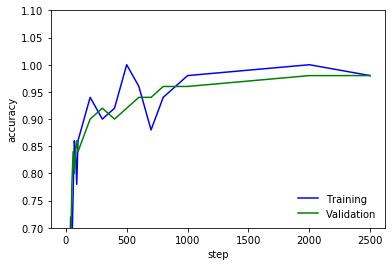

In [26]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):                # 验证集非空
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})   # 在验证集上评估模型
    print('validation_accuracy => %.4f'%validation_accuracy)          # 打印验证集的准确率
    plt.plot(x_range, train_accuracies,'-b', label='Training')        # 画训练集准确率的折线图 
    plt.plot(x_range, validation_accuracies,'-g', label='Validation') # 画验证集准确率的折线图
    plt.legend(loc='lower right', frameon=False)                      # 图例
    plt.ylim(ymax = 1.1, ymin = 0.7)                                  # y轴刻度
    plt.ylabel('accuracy')                                            # y轴名称
    plt.xlabel('step')                                                # x轴名称
    plt.show()                                                        # 展示图像

test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 5.0


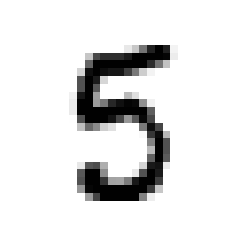

In [28]:
# read test data from CSV file 
test_images = pd.read_csv('./test.csv').values     # 读取测试集
test_images = test_images.astype(np.float)         # 转成浮点数

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)  # 除以255.0

print('test_images({0[0]},{0[1]})'.format(test_images.shape))  # 打印测试集的大小


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])     # 全0向量，大小为测试集样本数
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})    # 在测试集上进行预测


print('predicted_lables({0})'.format(len(predicted_lables)))            # 打印预测结果的大小

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])                                  # 展示测试集的第10个样本
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))  # 展示第10个样本的预测结果

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')             # 保存结果

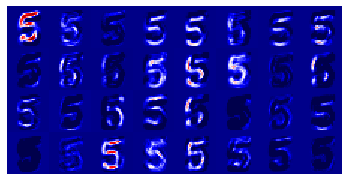

In [29]:
layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})   # 使用网络的第一层提取测试集特征
plt.axis('off')               # 关闭坐标轴
plt.imshow(layer1_grid[0], cmap=cm.seismic )   # 展示第一层第0个样本的输出特征

In [30]:
sess.close()     # 关闭会话